<a href="https://colab.research.google.com/github/kangel429/DeepLearning/blob/master/lesson6_rossmann_ipynb%EC%9D%98_%EC%82%AC%EB%B3%B8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.tabular import *

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
!ls '/content/drive/My Drive/rossmann/train_clean'

'/content/drive/My Drive/rossmann/train_clean'


# Rossmann

## Data preparation

To create the feature-engineered train_clean and test_clean from the Kaggle competition data, run `rossman_data_clean.ipynb`. One important step that deals with time series is this:

```python
add_datepart(train, "Date", drop=False)
add_datepart(test, "Date", drop=False)
```

 #경로설정        add_datepart() 라는 fastai 라이브러리 함수( 날짜 정보를 넣어주면 이 날짜 정보를 년/월/일 등으로 쪼개서 행을 만들어 주는 기능)
 # Pickle파일 읽기

In [0]:
path = Config().data_path()/'rossmann'   
path.mkdir(parents=True, exist_ok=True)      
!ls /root/.fastai/data/rossmann

In [0]:
! cp -r /content/drive/'My Drive'/rossmann/  /root/.fastai/data/

In [0]:
!ls /root/.fastai/data/rossmann

df		 models			store_states.csv  train.csv
googletrend.csv  sample_submission.csv	test_clean	  weather.csv
joined		 state_names.csv	test.csv
joined_test	 store.csv		train_clean


In [0]:
train_df = pd.read_pickle(path/'train_clean')  

In [0]:
train_df.head().T     # 상위 5 개의 자료 보여주기	    .T 속성은 DataFrame 에서 index 와 column 을 바꾼 형태의 DataFrame 입니다     그래서 column 5개까지 보여주는 것임

,0,1,2,3,4
index,0,1,2,3,4
Store,1,2,3,4,5
DayOfWeek,5,5,5,5,5
Date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
Sales,5263,6064,8314,13995,4822
...,...,...,...,...,...
StateHoliday_bw,0,0,0,0,0
Promo_bw,5,5,5,5,5
SchoolHoliday_fw,7,1,5,1,1
StateHoliday_fw,0,0,0,0,0


In [0]:
n = len(train_df); n        #개수 train_df

844338

### Experimenting with a sample

In [0]:
idx = np.random.permutation(range(n))[:2000]    #랜덤하게 리스트에서 조합 구하기 ~2000
idx.sort()        #순서대로 정리
small_train_df = train_df.iloc[idx[:1000]]    #idx 1000까지 읽기
small_test_df = train_df.iloc[idx[1000:]]     #idx 1000부터 읽기
small_cont_vars = ['CompetitionDistance', 'Mean_Humidity']
small_cat_vars =  ['Store', 'DayOfWeek', 'PromoInterval']
small_train_df = small_train_df[small_cat_vars + small_cont_vars + ['Sales']]  #small_train_df 카테고리 추가
small_test_df = small_test_df[small_cat_vars + small_cont_vars + ['Sales']]    #small_test_df 카테고리 추가

In [0]:
small_train_df.head()     #small_train_df   5개 보여주기

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
546,548,5,NaN,3760.0,54,5101
592,594,5,NaN,1790.0,61,5288
940,943,5,NaN,18020.0,61,8183
1495,384,4,"Jan,Apr,Jul,Oct",130.0,58,11088
3383,45,2,NaN,9710.0,43,5504


In [0]:
small_test_df.head()    #small_test_df   5개 보여주기

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
412695,841,4,NaN,27650.0,81,2575
412922,1068,4,"Jan,Apr,Jul,Oct",5010.0,57,3277
413130,161,3,NaN,2970.0,67,6532
413287,318,3,NaN,32330.0,67,5892
413449,480,3,NaN,300.0,71,4579


In [0]:
categorify = Categorify(small_cat_vars, small_cont_vars)  # categorify -- 문자열을 숫자로 바꿔줍니다.
categorify(small_train_df)
categorify(small_test_df, test=True)

In [0]:
small_test_df.head()

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales
412695,841,4,NaN,27650.0,81,2575
412922,1068,4,"Jan,Apr,Jul,Oct",5010.0,57,3277
413130,161,3,NaN,2970.0,67,6532
413287,NaN,3,NaN,32330.0,67,5892
413449,480,3,NaN,300.0,71,4579


In [0]:
small_train_df.PromoInterval.cat.categories  # PromoInterval 속성 문자열을 보여주기

Index(['Feb,May,Aug,Nov', 'Jan,Apr,Jul,Oct', 'Mar,Jun,Sept,Dec'], dtype='object')

In [0]:
small_train_df['PromoInterval'].cat.codes[:5]   # PromoInterval 속성값 보여주기

546    -1
592    -1
940    -1
1495    1
3383   -1
dtype: int8

In [0]:
fill_missing = FillMissing(small_cat_vars, small_cont_vars)
fill_missing(small_train_df)
fill_missing(small_test_df, test=True)

In [0]:
small_train_df[small_train_df['CompetitionDistance_na'] == True] #파일 미씽한 것을 체크하기

,Store,DayOfWeek,PromoInterval,CompetitionDistance,Mean_Humidity,Sales,CompetitionDistance_na
136905,879,4,"Feb,May,Aug,Nov",2590.0,76,4134,True
146355,291,1,NaN,2590.0,80,6425,True
252927,291,6,NaN,2590.0,82,4838,True
317637,291,2,NaN,2590.0,80,9729,True
366705,879,1,"Feb,May,Aug,Nov",2590.0,75,5886,True


### Preparing full data set

In [0]:
train_df = pd.read_pickle(path/'train_clean')  # Pickle파일 읽기
test_df = pd.read_pickle(path/'test_clean')      # Pickle파일 읽기

In [0]:
len(train_df),len(test_df)           # train_df 개수 확인  test_df 개수 확인 

(844338, 41088)

In [0]:
procs=[FillMissing, Categorify, Normalize]

In [0]:
cat_vars = ['Store', 'DayOfWeek', 'Year', 'Month', 'Day', 'StateHoliday', 'CompetitionMonthsOpen',
    'Promo2Weeks', 'StoreType', 'Assortment', 'PromoInterval', 'CompetitionOpenSinceYear', 'Promo2SinceYear',
    'State', 'Week', 'Events', 'Promo_fw', 'Promo_bw', 'StateHoliday_fw', 'StateHoliday_bw',
    'SchoolHoliday_fw', 'SchoolHoliday_bw']

cont_vars = ['CompetitionDistance', 'Max_TemperatureC', 'Mean_TemperatureC', 'Min_TemperatureC',
   'Max_Humidity', 'Mean_Humidity', 'Min_Humidity', 'Max_Wind_SpeedKm_h', 
   'Mean_Wind_SpeedKm_h', 'CloudCover', 'trend', 'trend_DE',
   'AfterStateHoliday', 'BeforeStateHoliday', 'Promo', 'SchoolHoliday']

In [0]:
dep_var = 'Sales'
df = train_df[cat_vars + cont_vars + [dep_var,'Date']].copy()       # 추가

In [0]:
test_df['Date'].min(), test_df['Date'].max()            #min() 최소 max() 최대

(Timestamp('2015-08-01 00:00:00'), Timestamp('2015-09-17 00:00:00'))

In [0]:
cut = train_df['Date'][(train_df['Date'] == train_df['Date'][len(test_df)])].index.max()    
cut

41395

In [0]:
valid_idx = range(cut)

In [0]:
df[dep_var].head()        

0     5263
1     6064
2     8314
3    13995
4     4822
Name: Sales, dtype: int64

In [0]:
data = (TabularList.from_df(df, path=path, cat_names=cat_vars, cont_names=cont_vars, procs=procs,)    #TabularList 파일 위치, 클래스 이름
                .split_by_idx(valid_idx)                                             #훈련 검증 나누기 (검증 인덱스만큼)
                .label_from_df(cols=dep_var, label_cls=FloatList, log=True)     #TabularList 라벨링 작업
                .add_test(TabularList.from_df(test_df, path=path, cat_names=cat_vars, cont_names=cont_vars))  #TabularList 라벨링 작업
                .databunch())   #데이터 브런치하기

In [0]:
doc(FloatList)

## Model

In [0]:
max_log_y = np.log(np.max(train_df['Sales'])*1.2)     #train_df최대값을 log로 계산
y_range = torch.tensor([0, max_log_y], device=defaults.device)

dropout /드랍아웃				훈련할 때 임의의 뉴런을 골라 삭제하여 신호를 전달하지 않게 한다. 테스트할 때는 모든 뉴런을 사용한다.
과적합(overfitting)의 위험을 줄이고 학습속도를 개선하는 등의 문제를 해결하기 위해 고안된 것이다

In [0]:
learn = tabular_learner(data, layers=[1000,500], ps=[0.001,0.01], emb_drop=0.04,    
                        y_range=y_range, metrics=exp_rmspe)        

 # 레이어 1000,출력활성화 500,  드롭아웃 사용 - 무작위로 비활성화 모델만들기

In [0]:
learn.model

TabularModel(
  (embeds): ModuleList(
    (0): Embedding(1116, 81)
    (1): Embedding(8, 5)
    (2): Embedding(4, 3)
    (3): Embedding(13, 7)
    (4): Embedding(32, 11)
    (5): Embedding(3, 3)
    (6): Embedding(26, 10)
    (7): Embedding(27, 10)
    (8): Embedding(5, 4)
    (9): Embedding(4, 3)
    (10): Embedding(4, 3)
    (11): Embedding(24, 9)
    (12): Embedding(9, 5)
    (13): Embedding(13, 7)
    (14): Embedding(53, 15)
    (15): Embedding(22, 9)
    (16): Embedding(7, 5)
    (17): Embedding(7, 5)
    (18): Embedding(4, 3)
    (19): Embedding(4, 3)
    (20): Embedding(9, 5)
    (21): Embedding(9, 5)
    (22): Embedding(3, 3)
    (23): Embedding(3, 3)
  )
  (emb_drop): Dropout(p=0.04, inplace=False)
  (bn_cont): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layers): Sequential(
    (0): Linear(in_features=233, out_features=1000, bias=True)
    (1): ReLU(inplace=True)
    (2): BatchNorm1d(1000, eps=1e-05, momentum=0.1, affine=True, track_runn

In [0]:
len(data.train_ds.cont_names)        # data.train_ds.cont_names 개수

16

In [0]:
learn.lr_find()           # 학습속도

epoch,train_loss,valid_loss,exp_rmspe,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


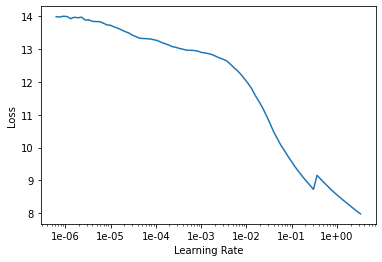

In [0]:
learn.recorder.plot()    # 그래프

In [0]:
learn.fit_one_cycle(5, 1e-3, wd=0.2)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.025803,0.035007,0.200936,04:10
1,0.019079,0.020572,0.130255,04:12
2,0.016761,0.017000,0.123864,04:11
3,0.012504,0.012093,0.107263,04:12
4,0.011188,0.010828,0.102608,04:12


In [0]:
learn.save('1')             # 저장

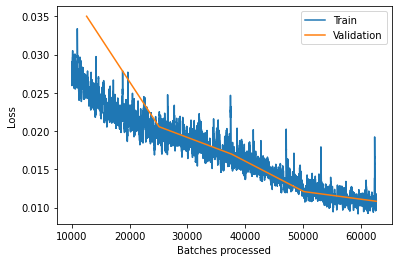

In [0]:
learn.recorder.plot_losses(skip_start=10000)      #단위 skip_start=10000  보여주기

In [0]:
learn.load('1');          

In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.012360,0.013264,0.117365,04:13
1,0.012561,0.013562,0.111372,04:13
2,0.010317,0.013383,0.115739,04:13
3,0.010185,0.012236,0.109188,04:15
4,0.009710,0.012460,0.111941,04:20


In [0]:
learn.fit_one_cycle(5, 3e-4)

epoch,train_loss,valid_loss,exp_rmspe,time
0,0.011803,0.013736,0.120390,04:21
1,0.010323,0.015083,0.135685,04:25
2,0.011010,0.015088,0.121215,04:18
3,0.009742,0.014113,0.123722,04:15
4,0.008761,0.015818,0.131950,04:17


(10th place in the competition was 0.108)

In [0]:
test_preds=learn.get_preds(DatasetType.Test)
test_df["Sales"]=np.exp(test_preds[0].data).numpy().T[0]      #np.exp 지수 .numpy()배열 함수
test_df[["Id","Sales"]]=test_df[["Id","Sales"]].astype("int")   #astype 문자열을 숫자형으로 
test_df[["Id","Sales"]].to_csv("rossmann_submission.csv",index=False)   # csv파일로 내보내기